In [1]:
# This notebook trains LSTM model on the preprocessed past data

# past_features = [
#     'alberta_internal_load',
#     'forecast_alberta_internal_load',
#     'pool_price',
#     'forecast_pool_price',
#     'rolling_30day_avg_price',
#     'solar_generation',
#     'wind_generation',
#     'temp_calgary',
#     'temp_edmonton',
#     'temp_fortmc',
#     'ws_calgary',
#     'ws_edmonton',
#     'ws_fortmc',
#     'datetime_',
#     'hour_of_day',
#     'day_of_week',
#     'day_of_month',
#     'week_of_month',
#     'month',
#     'year',
#     'is_winter'
# ]


# NVIDIA-SMI 535.183.01 
# CUDA Version: 10.1
# CUDNN Version: 
    #define CUDNN_MAJOR 7
    #define CUDNN_MINOR 6
    #define CUDNN_PATCHLEVEL 5
# Tensorflow Version: 2.2.0
# Python Version: 3.8.10

#### Library

In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set pandas display options efficiently
pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  

# Suppress specific warnings
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)


In [3]:
# check tf version
print('TensorFlow version:', tf.__version__)

#  Check if TensorFlow can access GPUs
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"TensorFlow is using GPU: {gpus}")
else:
    print("No GPU found, using CPU instead.")

TensorFlow version: 2.2.0
TensorFlow is using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-03-09 15:09:11.450416: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2025-03-09 15:09:11.491750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 15:09:11.492133: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce 940MX computeCapability: 5.0
coreClock: 1.189GHz coreCount: 3 deviceMemorySize: 3.95GiB deviceMemoryBandwidth: 37.33GiB/s
2025-03-09 15:09:11.493653: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2025-03-09 15:09:11.498312: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-09 15:09:11.511975: I tensorflow/stream_executor/platform

#### Data Loading

In [4]:
# Load the data
df2020 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2020/merged_df_2020_cleaned.csv')
df2021 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2021/merged_df_2021_cleaned.csv')
df2022 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2022/merged_df_2022_cleaned.csv')
df2023 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2023/merged_df_2023_cleaned.csv')
df2024 = pd.read_csv('/home/kevin/Downloads/BESS/data/raw/2024/merged_df_2024_cleaned.csv')

In [5]:
# concatenate all dataframes
df = pd.concat([df2020, df2021, df2022, df2023, df2024], axis=0, ignore_index=True)

In [6]:
df.shape

(43863, 69)

In [7]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter,pool_price_lag_1,pool_price_lag_2,pool_price_lag_3,pool_price_lag_4,pool_price_lag_5,pool_price_lag_6,pool_price_lag_7,pool_price_lag_8,pool_price_lag_9,pool_price_lag_10,pool_price_lag_11,pool_price_lag_12,pool_price_lag_13,pool_price_lag_14,pool_price_lag_15,pool_price_lag_16,pool_price_lag_17,pool_price_lag_18,pool_price_lag_19,pool_price_lag_20,pool_price_lag_21,pool_price_lag_22,pool_price_lag_23,pool_price_lag_24,alberta_internal_load_lag_1,alberta_internal_load_lag_2,alberta_internal_load_lag_3,alberta_internal_load_lag_4,alberta_internal_load_lag_5,alberta_internal_load_lag_6,alberta_internal_load_lag_7,alberta_internal_load_lag_8,alberta_internal_load_lag_9,alberta_internal_load_lag_10,alberta_internal_load_lag_11,alberta_internal_load_lag_12,alberta_internal_load_lag_13,alberta_internal_load_lag_14,alberta_internal_load_lag_15,alberta_internal_load_lag_16,alberta_internal_load_lag_17,alberta_internal_load_lag_18,alberta_internal_load_lag_19,alberta_internal_load_lag_20,alberta_internal_load_lag_21,alberta_internal_load_lag_22,alberta_internal_load_lag_23,alberta_internal_load_lag_24
0,2020-01-01 00:00:00,9467.0,9688.0,30.24,28.79,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
1,2020-01-01 01:00:00,9361.0,9541.0,29.43,28.19,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
2,2020-01-01 02:00:00,9286.0,9410.0,29.66,31.19,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
3,2020-01-01 03:00:00,9209.0,9328.0,28.19,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0
4,2020-01-01 04:00:00,9195.0,9319.0,31.17,28.19,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1,28.19,29.66,29.43,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,30.24,9209.0,9286.0,9361.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0,9467.0


#### Data Pre-processing

In [8]:
# Convert datetime_ column to datetime type
df['datetime_'] = pd.to_datetime(df['datetime_'])

# sort values by datetime_
df.sort_values('datetime_', inplace=True, ascending=True)

# remove lag terms
df.drop(columns = [col for col in df.columns if col.startswith('alberta_internal_load_lag')], inplace = True)
df.drop(columns = [col for col in df.columns if col.startswith('pool_price_lag')], inplace = True)

In [9]:
df.shape

(43863, 21)

In [10]:
df.head()

,datetime_,alberta_internal_load,forecast_alberta_internal_load,pool_price,forecast_pool_price,rolling_30day_avg_price,solar_generation,temp_calgary,temp_edmonton,temp_fortmc,wind_generation,ws_calgary,ws_edmonton,ws_fortmc,hour_of_day,day_of_week,day_of_month,week_of_month,month,year,is_winter
0,2020-01-01 00:00:00,9467.0,9688.0,30.24,28.79,43.49,0.0,2.2,-0.6,-2.7,875.637983,10.0,11.0,7.0,0,2,1,1,1,2020,1
1,2020-01-01 01:00:00,9361.0,9541.0,29.43,28.19,43.49,0.0,1.4,1.1,-4.6,778.695505,7.0,11.0,3.0,1,2,1,1,1,2020,1
2,2020-01-01 02:00:00,9286.0,9410.0,29.66,31.19,43.49,0.0,2.5,1.3,-7.0,717.339528,8.0,11.0,6.0,2,2,1,1,1,2020,1
3,2020-01-01 03:00:00,9209.0,9328.0,28.19,28.19,43.49,0.0,1.4,0.2,-5.2,691.670863,3.0,11.0,0.0,3,2,1,1,1,2020,1
4,2020-01-01 04:00:00,9195.0,9319.0,31.17,28.19,43.49,0.0,-0.3,0.4,-4.1,553.970998,0.0,11.0,4.0,4,2,1,1,1,2020,1


In [11]:
# check for missing observations
(df["datetime_"].diff().dt.total_seconds() // 3600).value_counts()

1.0    43847
0.0       15
Name: datetime_, dtype: int64

In [12]:
df.columns

Index(['datetime_', 'alberta_internal_load', 'forecast_alberta_internal_load',
       'pool_price', 'forecast_pool_price', 'rolling_30day_avg_price',
       'solar_generation', 'temp_calgary', 'temp_edmonton', 'temp_fortmc',
       'wind_generation', 'ws_calgary', 'ws_edmonton', 'ws_fortmc',
       'hour_of_day', 'day_of_week', 'day_of_month', 'week_of_month', 'month',
       'year', 'is_winter'],
      dtype='object')

In [13]:
target_column = "pool_price"

# Exclude datetime column
df = df.drop(columns=["datetime_"])

# Separate features and target
X = df.values 
y = df[target_column].values

# Normalize features using StandardScaler
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Function to create sequences for LSTM
def create_sequences(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X) - time_steps - time_steps):
        Xs.append(X[i : i + time_steps])   
        # ys.append(y[i + 1 : i + 1 + time_steps])  
        ys.append(y[i + time_steps : i + time_steps + time_steps])  
    return np.array(Xs), np.array(ys)

# Define sequence length (24 hours)
time_steps = 24
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)
# X_seq, y_seq = create_sequences(X, y, time_steps)
print(X_seq.shape, y_seq.shape)

(43815, 24, 20) (43815, 24, 1)


#### Train-Test split

In [14]:
# Split into training and testing sets
train_size = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# shape of training and testing sets
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(35052, 24, 20) (8763, 24, 20)
(35052, 24, 1) (8763, 24, 1)


#### LSTM modeling

In [15]:
# Build LSTM Model
model = Sequential([
    Input(shape=(X_train.shape[1], X_train.shape[2])), 
    LSTM(64, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', recurrent_activation='sigmoid', use_bias=True, return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(24)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Print model summary
model.summary()

2025-03-09 15:09:14.430800: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2025-03-09 15:09:14.465373: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2699905000 Hz
2025-03-09 15:09:14.465867: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5278000b60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-03-09 15:09:14.465929: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-03-09 15:09:14.530635: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-03-09 15:09:14.531285: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0xf812390 initialized for platform CUDA (this does not guarantee that XLA will

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 24, 64)            21760     
_________________________________________________________________
dropout (Dropout)            (None, 24, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
Total params: 35,112
Trainable params: 35,112
Non-trainable params: 0
____________________________________________________

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10


2025-03-09 15:09:23.905115: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-09 15:09:24.188129: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


877/877 [==============================] - 12s 13ms/step - loss: 0.6662 - mae: 0.4275 - val_loss: 1.2780 - val_mae: 0.7928
Epoch 2/10
877/877 [==============================] - 11s 12ms/step - loss: 0.4855 - mae: 0.3639 - val_loss: 1.4118 - val_mae: 0.7810
Epoch 3/10
877/877 [==============================] - 10s 12ms/step - loss: 0.4177 - mae: 0.3364 - val_loss: 1.3690 - val_mae: 0.7507
Epoch 4/10
877/877 [==============================] - 10s 11ms/step - loss: 0.3854 - mae: 0.3218 - val_loss: 1.3832 - val_mae: 0.7563
Epoch 5/10
877/877 [==============================] - 10s 11ms/step - loss: 0.3616 - mae: 0.3110 - val_loss: 1.3530 - val_mae: 0.7400
Epoch 6/10
877/877 [==============================] - 10s 11ms/step - loss: 0.3381 - mae: 0.3006 - val_loss: 1.5031 - val_mae: 0.7833
Epoch 7/10
877/877 [==============================] - 10s 11ms/step - loss: 0.3252 - mae: 0.2941 - val_loss: 1.4021 - val_mae: 0.7561
Epoch 8/10
877/877 [==============================] - 10s 11ms/step - los

#### Model Performance Check

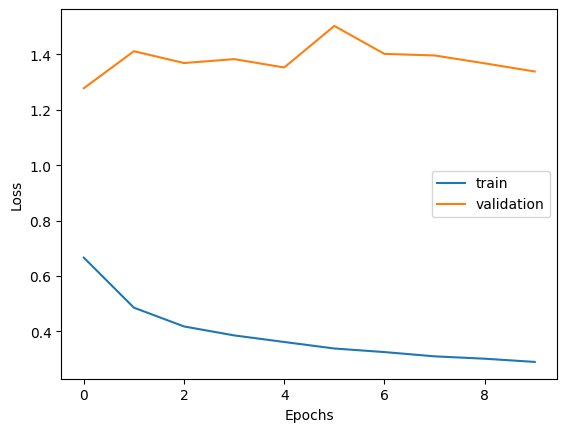

In [17]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [18]:
# Predict on test data
y_test_pred = model.predict(X_test)

# Reverse scaling
y_test_pred_inv = scaler_y.inverse_transform(y_test_pred)
y_test_inv = scaler_y.inverse_transform(y_test.reshape(y_test.shape[0], y_test.shape[1]))

# Compute performance metrics
mae = mean_absolute_error(y_test_inv, y_test_pred_inv)
r2 = r2_score(y_test_inv, y_test_pred_inv)

print(f"Test MAE: {mae:.2f}")
print(f"Test R² Score: {r2:.2f}")

Test MAE: 82.56
Test R² Score: -0.12


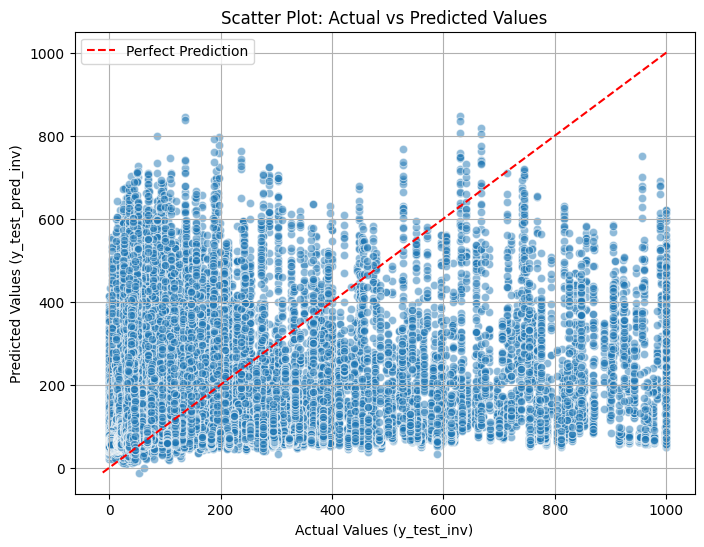

In [19]:
# Flatten the arrays to convert (7011, 24) → (7011*24,)
y_test_inv_flat = y_test_inv.flatten()
y_test_pred_inv_flat = y_test_pred_inv.flatten()

# Create the scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_inv_flat, y=y_test_pred_inv_flat, alpha=0.5)

# Plot a perfect prediction reference line (y = x)
min_val = min(y_test_inv_flat.min(), y_test_pred_inv_flat.min())
max_val = max(y_test_inv_flat.max(), y_test_pred_inv_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label="Perfect Prediction")

# Labels and title
plt.xlabel("Actual Values (y_test_inv)")
plt.ylabel("Predicted Values (y_test_pred_inv)")
plt.title("Scatter Plot: Actual vs Predicted Values")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

#### Hourly Statistics

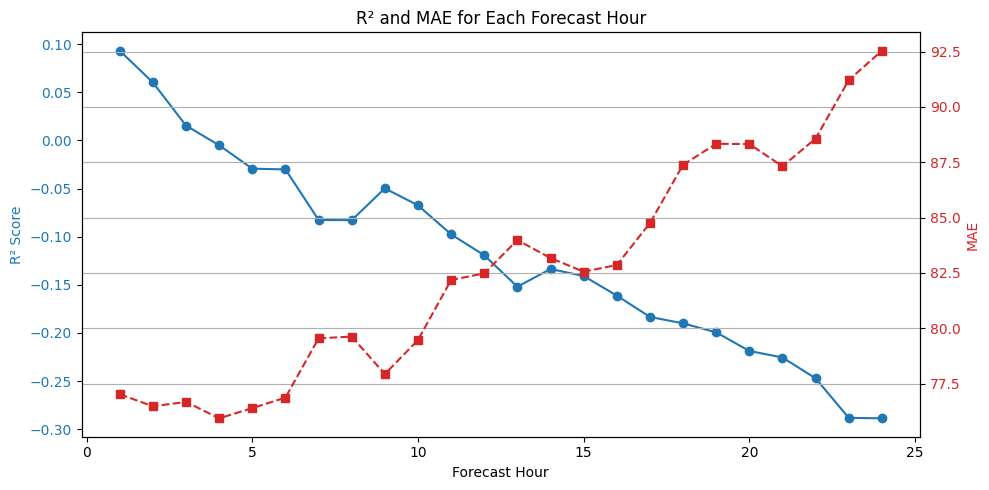

In [20]:
# Initialize lists to store R² and MAE values for each forecast hour
r2_scores = []  
mae_scores = []

# Loop through each forecast hour (24 hours)
for hour in range(24):
    # Calculate R² and MAE for the current hour
    r2 = r2_score(y_test_inv[:, hour], y_test_pred_inv[:, hour])
    mae = mean_absolute_error(y_test_inv[:, hour], y_test_pred_inv[:, hour])
    
    # Append the scores to their respective lists
    r2_scores.append(r2)
    mae_scores.append(mae)

# Convert the lists to NumPy arrays for easy plotting
r2_scores = np.array(r2_scores)
mae_scores = np.array(mae_scores)

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot R² scores on the first y-axis
ax1.set_xlabel("Forecast Hour")  # Label for x-axis
ax1.set_ylabel("R² Score", color="tab:blue")  # Label for left y-axis
ax1.plot(range(1, 25), r2_scores, marker="o", linestyle="-", color="tab:blue", label="R² Score")  # R² plot
ax1.tick_params(axis="y", labelcolor="tab:blue")  # Customize ticks for left y-axis
# ax1.set_ylim(-1, 1)  # R² can be negative, so set the limit between -1 and 1

# Create a second y-axis for MAE
ax2 = ax1.twinx()
ax2.set_ylabel("MAE", color="tab:red")  # Label for right y-axis
ax2.plot(range(1, 25), mae_scores, marker="s", linestyle="--", color="tab:red", label="MAE")  # MAE plot
ax2.tick_params(axis="y", labelcolor="tab:red")  # Customize ticks for right y-axis

# Add a title and layout adjustments
plt.title("R² and MAE for Each Forecast Hour")  # Title for the plot
fig.tight_layout()  # Adjust layout to prevent overlap

# Display the plot
plt.grid()
plt.show()


In [21]:
# run scripts and extract past 24 hours data
# engineer the remaining features
# scale the data
# make predictions